<a href="https://colab.research.google.com/github/PaulToronto/Stanford-Andrew-Ng-Machine-Learning-Specialization/blob/main/1_2_2_1_Lab_Feature_scaling_and_learning_rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab - Feature scaling and learning rate

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
import copy
import seaborn as sns

from sklearn.linear_model import LinearRegression

np.set_printoptions(precision=2)

## The Data

In [2]:
X_train = np.array([[1.24e+03, 3.00e+00, 1.00e+00, 6.40e+01],
       [1.95e+03, 3.00e+00, 2.00e+00, 1.70e+01],
       [1.72e+03, 3.00e+00, 2.00e+00, 4.20e+01],
       [1.96e+03, 3.00e+00, 2.00e+00, 1.50e+01],
       [1.31e+03, 2.00e+00, 1.00e+00, 1.40e+01],
       [8.64e+02, 2.00e+00, 1.00e+00, 6.60e+01],
       [1.84e+03, 3.00e+00, 1.00e+00, 1.70e+01],
       [1.03e+03, 3.00e+00, 1.00e+00, 4.30e+01],
       [3.19e+03, 4.00e+00, 2.00e+00, 8.70e+01],
       [7.88e+02, 2.00e+00, 1.00e+00, 8.00e+01],
       [1.20e+03, 2.00e+00, 2.00e+00, 1.70e+01],
       [1.56e+03, 2.00e+00, 1.00e+00, 1.80e+01],
       [1.43e+03, 3.00e+00, 1.00e+00, 2.00e+01],
       [1.22e+03, 2.00e+00, 1.00e+00, 1.50e+01],
       [1.09e+03, 2.00e+00, 1.00e+00, 6.40e+01],
       [8.48e+02, 1.00e+00, 1.00e+00, 1.70e+01],
       [1.68e+03, 3.00e+00, 2.00e+00, 2.30e+01],
       [1.77e+03, 3.00e+00, 2.00e+00, 1.80e+01],
       [1.04e+03, 3.00e+00, 1.00e+00, 4.40e+01],
       [1.65e+03, 2.00e+00, 1.00e+00, 2.10e+01],
       [1.09e+03, 2.00e+00, 1.00e+00, 3.50e+01],
       [1.32e+03, 3.00e+00, 1.00e+00, 1.40e+01],
       [1.59e+03, 0.00e+00, 1.00e+00, 2.00e+01],
       [9.72e+02, 2.00e+00, 1.00e+00, 7.30e+01],
       [1.10e+03, 3.00e+00, 1.00e+00, 3.70e+01],
       [1.00e+03, 2.00e+00, 1.00e+00, 5.10e+01],
       [9.04e+02, 3.00e+00, 1.00e+00, 5.50e+01],
       [1.69e+03, 3.00e+00, 1.00e+00, 1.30e+01],
       [1.07e+03, 2.00e+00, 1.00e+00, 1.00e+02],
       [1.42e+03, 3.00e+00, 2.00e+00, 1.90e+01],
       [1.16e+03, 3.00e+00, 1.00e+00, 5.20e+01],
       [1.94e+03, 3.00e+00, 2.00e+00, 1.20e+01],
       [1.22e+03, 2.00e+00, 2.00e+00, 7.40e+01],
       [2.48e+03, 4.00e+00, 2.00e+00, 1.60e+01],
       [1.20e+03, 2.00e+00, 1.00e+00, 1.80e+01],
       [1.84e+03, 3.00e+00, 2.00e+00, 2.00e+01],
       [1.85e+03, 3.00e+00, 2.00e+00, 5.70e+01],
       [1.66e+03, 3.00e+00, 2.00e+00, 1.90e+01],
       [1.10e+03, 2.00e+00, 2.00e+00, 9.70e+01],
       [1.78e+03, 3.00e+00, 2.00e+00, 2.80e+01],
       [2.03e+03, 4.00e+00, 2.00e+00, 4.50e+01],
       [1.78e+03, 4.00e+00, 2.00e+00, 1.07e+02],
       [1.07e+03, 2.00e+00, 1.00e+00, 1.00e+02],
       [1.55e+03, 3.00e+00, 1.00e+00, 1.60e+01],
       [1.95e+03, 3.00e+00, 2.00e+00, 1.60e+01],
       [1.22e+03, 2.00e+00, 2.00e+00, 1.20e+01],
       [1.62e+03, 3.00e+00, 1.00e+00, 1.60e+01],
       [8.16e+02, 2.00e+00, 1.00e+00, 5.80e+01],
       [1.35e+03, 3.00e+00, 1.00e+00, 2.10e+01],
       [1.57e+03, 3.00e+00, 1.00e+00, 1.40e+01],
       [1.49e+03, 3.00e+00, 1.00e+00, 5.70e+01],
       [1.51e+03, 2.00e+00, 1.00e+00, 1.60e+01],
       [1.10e+03, 3.00e+00, 1.00e+00, 2.70e+01],
       [1.76e+03, 3.00e+00, 2.00e+00, 2.40e+01],
       [1.21e+03, 2.00e+00, 1.00e+00, 1.40e+01],
       [1.47e+03, 3.00e+00, 2.00e+00, 2.40e+01],
       [1.77e+03, 3.00e+00, 2.00e+00, 8.40e+01],
       [1.65e+03, 3.00e+00, 1.00e+00, 1.90e+01],
       [1.03e+03, 3.00e+00, 1.00e+00, 6.00e+01],
       [1.12e+03, 2.00e+00, 2.00e+00, 1.60e+01],
       [1.15e+03, 3.00e+00, 1.00e+00, 6.20e+01],
       [8.16e+02, 2.00e+00, 1.00e+00, 3.90e+01],
       [1.04e+03, 3.00e+00, 1.00e+00, 2.50e+01],
       [1.39e+03, 3.00e+00, 1.00e+00, 6.40e+01],
       [1.60e+03, 3.00e+00, 2.00e+00, 2.90e+01],
       [1.22e+03, 3.00e+00, 1.00e+00, 6.30e+01],
       [1.07e+03, 2.00e+00, 1.00e+00, 1.00e+02],
       [2.60e+03, 4.00e+00, 2.00e+00, 2.20e+01],
       [1.43e+03, 3.00e+00, 1.00e+00, 5.90e+01],
       [2.09e+03, 3.00e+00, 2.00e+00, 2.60e+01],
       [1.79e+03, 4.00e+00, 2.00e+00, 4.90e+01],
       [1.48e+03, 3.00e+00, 2.00e+00, 1.60e+01],
       [1.04e+03, 3.00e+00, 1.00e+00, 2.50e+01],
       [1.43e+03, 3.00e+00, 1.00e+00, 2.20e+01],
       [1.16e+03, 3.00e+00, 1.00e+00, 5.30e+01],
       [1.55e+03, 3.00e+00, 2.00e+00, 1.20e+01],
       [1.98e+03, 3.00e+00, 2.00e+00, 2.20e+01],
       [1.06e+03, 3.00e+00, 1.00e+00, 5.30e+01],
       [1.18e+03, 2.00e+00, 1.00e+00, 9.90e+01],
       [1.36e+03, 2.00e+00, 1.00e+00, 1.70e+01],
       [9.60e+02, 3.00e+00, 1.00e+00, 5.10e+01],
       [1.46e+03, 3.00e+00, 2.00e+00, 1.60e+01],
       [1.45e+03, 3.00e+00, 2.00e+00, 2.50e+01],
       [1.21e+03, 2.00e+00, 1.00e+00, 1.50e+01],
       [1.55e+03, 3.00e+00, 2.00e+00, 1.60e+01],
       [8.82e+02, 3.00e+00, 1.00e+00, 4.90e+01],
       [2.03e+03, 4.00e+00, 2.00e+00, 4.50e+01],
       [1.04e+03, 3.00e+00, 1.00e+00, 6.20e+01],
       [1.62e+03, 3.00e+00, 1.00e+00, 1.60e+01],
       [8.03e+02, 2.00e+00, 1.00e+00, 8.00e+01],
       [1.43e+03, 3.00e+00, 2.00e+00, 2.10e+01],
       [1.66e+03, 3.00e+00, 1.00e+00, 6.10e+01],
       [1.54e+03, 3.00e+00, 1.00e+00, 1.60e+01],
       [9.48e+02, 3.00e+00, 1.00e+00, 5.30e+01],
       [1.22e+03, 2.00e+00, 2.00e+00, 1.20e+01],
       [1.43e+03, 2.00e+00, 1.00e+00, 4.30e+01],
       [1.66e+03, 3.00e+00, 2.00e+00, 1.90e+01],
       [1.21e+03, 3.00e+00, 1.00e+00, 2.00e+01],
       [1.05e+03, 2.00e+00, 1.00e+00, 6.50e+01]])
y_train = np.array([300.  , 509.8 , 394.  , 540.  , 415.  , 230.  , 560.  , 294.  ,
       718.2 , 200.  , 302.  , 468.  , 374.2 , 388.  , 282.  , 311.8 ,
       401.  , 449.8 , 301.  , 502.  , 340.  , 400.28, 572.  , 264.  ,
       304.  , 298.  , 219.8 , 490.7 , 216.96, 368.2 , 280.  , 526.87,
       237.  , 562.43, 369.8 , 460.  , 374.  , 390.  , 158.  , 426.  ,
       390.  , 277.77, 216.96, 425.8 , 504.  , 329.  , 464.  , 220.  ,
       358.  , 478.  , 334.  , 426.98, 290.  , 463.  , 390.8 , 354.  ,
       350.  , 460.  , 237.  , 288.3 , 282.  , 249.  , 304.  , 332.  ,
       351.8 , 310.  , 216.96, 666.34, 330.  , 480.  , 330.3 , 348.  ,
       304.  , 384.  , 316.  , 430.4 , 450.  , 284.  , 275.  , 414.  ,
       258.  , 378.  , 350.  , 412.  , 373.  , 225.  , 390.  , 267.4 ,
       464.  , 174.  , 340.  , 430.  , 440.  , 216.  , 329.  , 388.  ,
       390.  , 356.  , 257.8 ])

In [3]:
houses = pd.DataFrame(X_train)
X_features = ['size_sqft', 'bedrooms', 'floors', 'age']
houses.columns = X_features
houses['price'] = y_train
houses

,size_sqft,bedrooms,floors,age,price
0,1240.0,3.0,1.0,64.0,300.0
1,1950.0,3.0,2.0,17.0,509.8
2,1720.0,3.0,2.0,42.0,394.0
3,1960.0,3.0,2.0,15.0,540.0
4,1310.0,2.0,1.0,14.0,415.0
...,...,...,...,...,...
94,1220.0,2.0,2.0,12.0,329.0
95,1430.0,2.0,1.0,43.0,388.0
96,1660.0,3.0,2.0,19.0,390.0
97,1210.0,3.0,1.0,20.0,356.0


## Visualize Features vs. Target

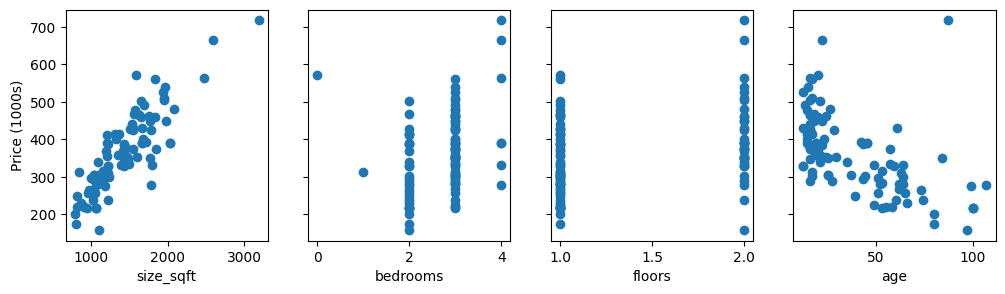

In [4]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3), sharey=True)

for i in range(len(ax)):
    ax[i].scatter(X_train[:, i], y_train)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel('Price (1000s)')

plt.show()

## Gradient Descent With Multiple Variables
Here are the equations you developed in the last lab on gradient descent for multiple variables.:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j}   \; & \text{for j = 0..n-1}\newline
&b\ \ := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

where, n is the number of features, parameters $w_j$,  $b$, are updated simultaneously and where  

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})
\end{align}
$$
* m is the number of training examples in the data set

    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value

## Functions

In [5]:
def f_wb(X, w, b):
    m = X.shape[0]
    pred = X @ w + b
    return pred

In [6]:
def compute_cost(X, y, w, b):
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters
      b (scalar)       : model parameter

    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        f_wb_i = w.dot(X[i]) + b
        cost = cost + (f_wb_i - y[i])**2
    cost = cost / (2 * m)
    return cost

In [7]:
def compute_gradient(X, y, w, b):
    """
    Computes the gradient for linear regression
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters
      b (scalar)       : model parameter

    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w.
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b.
    """
    m, n = X.shape
    dj_dw = np.zeros((n, ))
    dj_db = 0.0

    for i in range(m):
        err = w.dot(X[i]) + b - y[i]
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err * X[i, j]
        dj_db = dj_db + err

    dj_dw = dj_dw / m
    dj_db = dj_db / m

    return dj_db, dj_dw


In [8]:
def gradient_descent(X, y, w_in, b_in, f_cost, f_gradient, alpha, num_iters):
    """
    Performs batch gradient descent to learn w and b. Updates w and b by taking
    num_iters gradient steps with learning rate alpha

    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent

    Returns:
      w (ndarray (n,)) : Updated values of parameters
      b (scalar)       : Updated value of parameter
    """
    J_history = []
    w = copy.deepcopy(w_in) # avoid modify global w within function
    b = b_in

    for i in range(num_iters):
        # calculate the gradient
        dj_db, dj_dw = f_gradient(X, y, w, b)
        collect_w = []

        # update the parameters
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        if i < 100_000: # prevent resource exhaustion
            J_history.append(f_cost(X, y, w, b))

        # print cost
        if i % ceil(num_iters / 10) == 0:
            print(f'Iteration {i:4d}: Cost {J_history[-1]:8.2f}: w {w}: b {b}')

    return w, b, J_history

## Run Gradient Descent

In [9]:
iterations = 10
w_init = np.array([0.0, 0.0, 0.0, 0.0])
b_init = 0.0

### $\alpha = 9.9e-7$

In [10]:
alpha = 9.9e-7

In [11]:
w, b, j_hist = gradient_descent(X_train, y_train, w_init, b_init, compute_cost, compute_gradient, alpha, iterations)

Iteration    0: Cost 95571.39: w [5.46e-01 9.96e-04 5.13e-04 1.23e-02]: b 0.0003595245
Iteration    1: Cost 128166.31: w [-0.09 -0.   -0.   -0.  ]: b -4.850209459962421e-05
Iteration    2: Cost 172064.39: w [6.48e-01 1.17e-03 5.94e-04 1.34e-02]: b 0.0004342249169734736
Iteration    3: Cost 231185.23: w [-0.21 -0.   -0.   -0.01]: b -0.00011676522648379885
Iteration    4: Cost 310807.65: w [7.85e-01 1.41e-03 7.08e-04 1.53e-02]: b 0.0005318852451677565
Iteration    5: Cost 418041.03: w [-0.36 -0.   -0.   -0.01]: b -0.0002116463423887428
Iteration    6: Cost 562460.06: w [9.70e-01 1.73e-03 8.68e-04 1.83e-02]: b 0.000660462955897121
Iteration    7: Cost 756959.66: w [-0.58 -0.   -0.   -0.02]: b -0.0003423801759095188
Iteration    8: Cost 1018906.38: w [1.22e+00 2.18e-03 1.09e-03 2.29e-02]: b 0.0008306749539000222
Iteration    9: Cost 1371688.94: w [-0.87 -0.   -0.   -0.03]: b -0.0005214037966026461


In [12]:
w

array([-0.87, -0.  , -0.  , -0.03])

In [13]:
b

-0.0005214037966026461

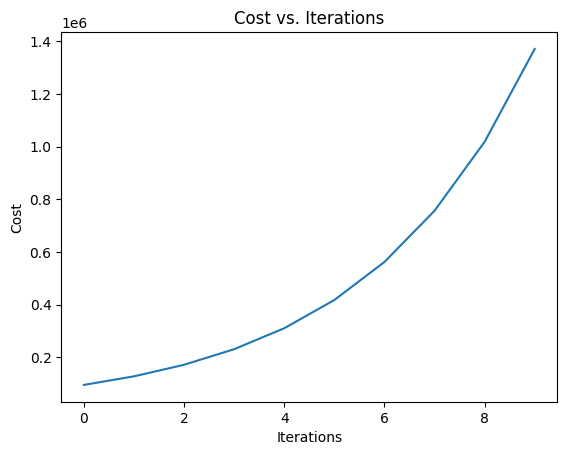

In [14]:
plt.plot(j_hist)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs. Iterations')
plt.show()

The solution is not converging. Try a smaller $\alpha$.

### $\alpha = 9e-7$

In [15]:
alpha = 9e-7

In [16]:
w, b, j_hist = gradient_descent(X_train, y_train, w_init, b_init, compute_cost, compute_gradient, alpha, iterations)

Iteration    0: Cost 66446.95: w [4.97e-01 9.05e-04 4.67e-04 1.12e-02]: b 0.0003268404545454545
Iteration    1: Cost 61871.76: w [ 1.79e-02  2.07e-05  2.02e-06 -7.86e-04]: b 1.934116148791411e-05
Iteration    2: Cost 57619.17: w [4.79e-01 8.62e-04 4.35e-04 9.55e-03]: b 0.0003234109869223036
Iteration    3: Cost 53666.46: w [ 3.45e-02  3.91e-05  2.84e-06 -1.60e-03]: b 3.78749488625188e-05
Iteration    4: Cost 49992.46: w [4.64e-01 8.21e-04 4.05e-04 7.96e-03]: b 0.00032078029004924406
Iteration    5: Cost 46577.52: w [ 4.99e-02  5.54e-05  2.55e-06 -2.44e-03]: b 5.565901338249851e-05
Iteration    6: Cost 43403.38: w [4.49e-01 7.81e-04 3.76e-04 6.41e-03]: b 0.0003188927490934103
Iteration    7: Cost 40453.05: w [ 6.42e-02  6.97e-05  1.22e-06 -3.30e-03]: b 7.274693955777636e-05
Iteration    8: Cost 37710.75: w [4.35e-01 7.44e-04 3.48e-04 4.88e-03]: b 0.00031769667001073343
Iteration    9: Cost 35161.82: w [ 7.76e-02  8.22e-05 -1.07e-06 -4.19e-03]: b 8.918853193899413e-05


In [17]:
w

array([ 7.76e-02,  8.22e-05, -1.07e-06, -4.19e-03])

In [18]:
b

8.918853193899413e-05

The solution is now converging, so $\alpha$ is not too large, but it does not appear to be leveling off. Maybe an even smaller value for $\alpha$?

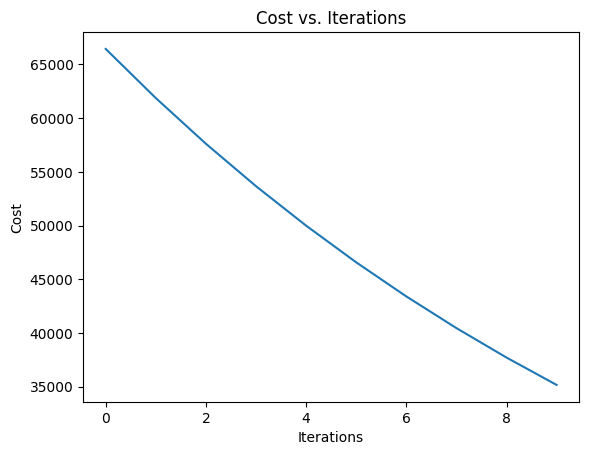

In [19]:
plt.plot(j_hist)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs. Iterations')
plt.show()

### $\alpha = 1e-7$

In [20]:
alpha = 1e-7

In [21]:
w, b, j_hist = gradient_descent(X_train, y_train, w_init, b_init, compute_cost, compute_gradient, alpha, iterations)

Iteration    0: Cost 44230.48: w [5.52e-02 1.01e-04 5.19e-05 1.24e-03]: b 3.631560606060606e-05
Iteration    1: Cost 27644.33: w [9.83e-02 1.79e-04 9.22e-05 2.20e-03]: b 6.479985721253318e-05
Iteration    2: Cost 17507.53: w [1.32e-01 2.40e-04 1.24e-04 2.93e-03]: b 8.71618191157195e-05
Iteration    3: Cost 11312.30: w [1.58e-01 2.88e-04 1.48e-04 3.48e-03]: b 0.00010473758321152661
Iteration    4: Cost  7526.01: w [1.79e-01 3.25e-04 1.67e-04 3.91e-03]: b 0.00011857166193811669
Iteration    5: Cost  5211.97: w [1.95e-01 3.54e-04 1.81e-04 4.22e-03]: b 0.00012948062083847185
Iteration    6: Cost  3797.69: w [2.08e-01 3.77e-04 1.92e-04 4.45e-03]: b 0.00013810282405406
Iteration    7: Cost  2933.33: w [2.18e-01 3.94e-04 2.01e-04 4.62e-03]: b 0.00014493732371915314
Iteration    8: Cost  2405.05: w [2.25e-01 4.07e-04 2.08e-04 4.73e-03]: b 0.00015037426241296914
Iteration    9: Cost  2082.17: w [2.31e-01 4.18e-04 2.12e-04 4.81e-03]: b 0.0001547186407989581


In [22]:
w

array([2.31e-01, 4.18e-04, 2.12e-04, 4.81e-03])

In [23]:
b

0.0001547186407989581

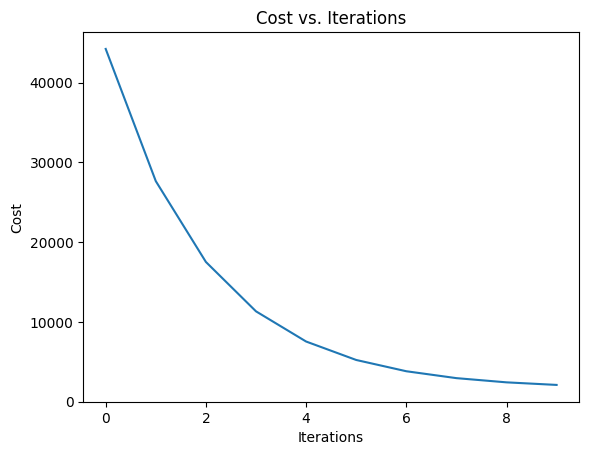

In [24]:
plt.plot(j_hist)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs. Iterations')
plt.show()

## Feature Scaling

### z-score normaliztion

After z-score normalization, all features will have a mean of 0 and a standard deviation of 1

$$x^{(i)}_j = \dfrac{x^{(i)}_j - \mu_j}{\sigma_j}$$

In [25]:
def zscore_normalize_features(X):
    """
    computes  X, zcore normalized by column

    Args:
      X (ndarray (m,n))     : input data, m examples, n features

    Returns:
      X_norm (ndarray (m,n)): input normalized by column
      mu (ndarray (n,))     : mean of each feature
      sigma (ndarray (n,))  : standard deviation of each feature
    """
    # find the mean of each feature
    mu = np.mean(X, axis=0)
    # find the standard deviation of each feature
    sigma = np.std(X, axis=0)
    # element-wise, subtract mean for each column and divide by standard deviation
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

### The relationship between `size_sqft` and `age`, before and after z-score normalization

- Note that these are plotted with **equal scale**

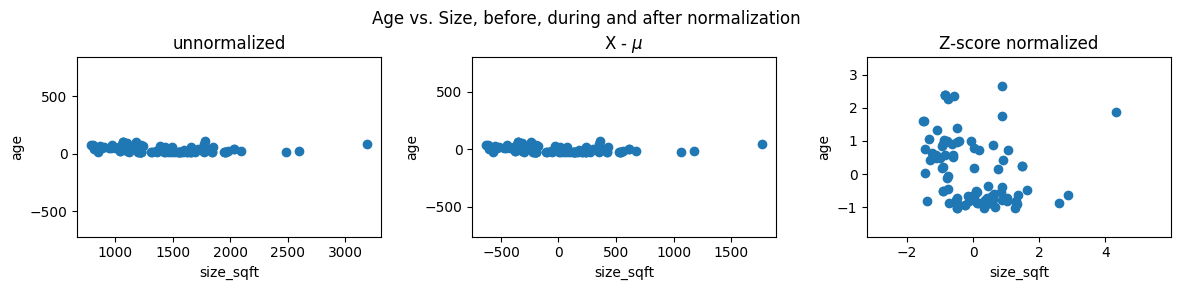

In [26]:
X_norm, X_mu, X_sigma = zscore_normalize_features(X_train)
X_mean = X_train - X_mu

fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].scatter(X_train[:, 0], X_train[:, 3])
ax[0].set_xlabel(X_features[0])
ax[0].set_ylabel(X_features[3])
ax[0].set_title('unnormalized')
ax[0].axis('equal')

ax[1].scatter(X_mean[:, 0], X_mean[:, 3])
ax[1].set_xlabel(X_features[0])
ax[1].set_ylabel(X_features[3])
ax[1].set_title(r'X - $\mu$')
ax[1].axis('equal')

ax[2].scatter(X_norm[:, 0], X_norm[:, 3])
ax[2].set_xlabel(X_features[0])
ax[2].set_ylabel(X_features[3])
ax[2].set_title('Z-score normalized')
ax[2].axis('equal')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Age vs. Size, before, during and after normalization')

plt.show()

### Comparing `X_train`, to `X_norm`

In [27]:
X_train[:, 0].min(), X_train[:, 0].max()

(788.0, 3190.0)

In [28]:
X_train[:, 0].ptp(), X_train[:, 0].max() - X_train[:, 0].min()

(2402.0, 2402.0)

In [29]:
print(f"X_mu = {X_mu}, \nX_sigma = {X_sigma}")
print(f"Peak to Peak range by column in Raw        X:{np.ptp(X_train,axis=0)}")
print(f"Peak to Peak range by column in Normalized X:{np.ptp(X_norm,axis=0)}")

X_mu = [1.42e+03 2.72e+00 1.38e+00 3.84e+01], 
X_sigma = [411.4    0.65   0.49  25.78]
Peak to Peak range by column in Raw        X:[2.4e+03 4.0e+00 1.0e+00 9.5e+01]
Peak to Peak range by column in Normalized X:[5.84 6.14 2.06 3.69]


Notice the reduction in the **peak to peak range** of each feature.

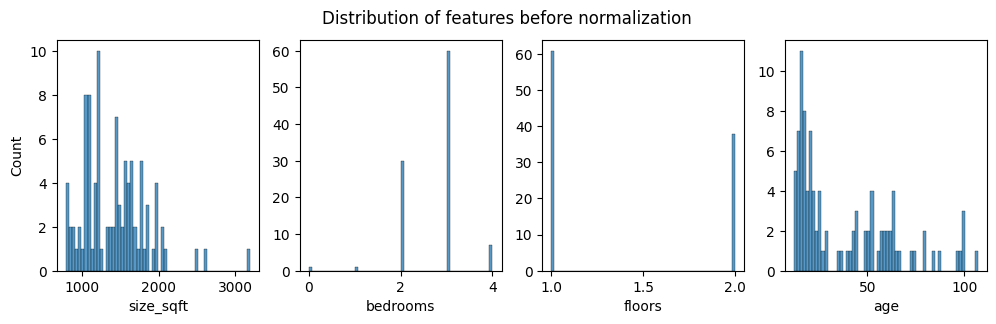

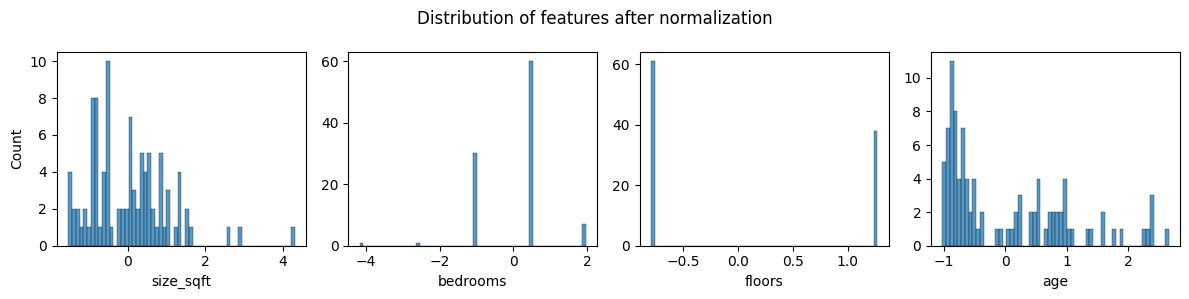

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
for i in range(len(ax)):
    sns.histplot(X_train[:, i], bins=60, ax=ax[i])
    ax[i].set(xlabel=X_features[i], ylabel=None)
ax[0].set_ylabel('Count')
fig.suptitle('Distribution of features before normalization')
plt.show()

fig, ax = plt.subplots(1, 4, figsize=(12, 3))
for i in range(len(ax)):
    sns.histplot(X_norm[:, i], bins=60, ax=ax[i])
    ax[i].set(xlabel=X_features[i], ylabel=None)
ax[0].set_ylabel('Count')
fig.suptitle('Distribution of features after normalization')
plt.tight_layout()
plt.show()

### Running Gradient Descent After Z-score Normalization

In [31]:
iterations = 10
w_init = np.array([0.0, 0.0, 0.0, 0.0])
b_init = 0.0
iterations = 10

#### $\alpha = 1.0e-1$

In [32]:
alpha = 1.0e-1

In [33]:
# this is NOT converging
w, b, j_hist = gradient_descent(X_train, y_train, w_init, b_init, compute_cost, compute_gradient, alpha, iterations)

Iteration    0: Cost 3323950096275833.50: w [5.52e+04 1.01e+02 5.19e+01 1.24e+03]: b 36.31560606060606
Iteration    1: Cost 158303545740417816447680512.00: w [-1.20e+10 -2.21e+07 -1.15e+07 -2.85e+08]: b -7831282.277466833
Iteration    2: Cost 7539226487570573978981156377497436160.00: w [2.63e+15 4.82e+12 2.51e+12 6.23e+13]: b 1709042165982.3904
Iteration    3: Cost 359056619768267684934877854438604209620976140288.00: w [-5.73e+20 -1.05e+18 -5.48e+17 -1.36e+19]: b -3.729673823609419e+17
Iteration    4: Cost 17100117155514428764900997430615216838529877267968086245376.00: w [1.25e+26 2.30e+23 1.19e+23 2.97e+24]: b 8.139335052318987e+22
Iteration    5: Cost 814395253096964818660352484289255518136543941872849997867742010540032.00: w [-2.73e+31 -5.01e+28 -2.61e+28 -6.47e+29]: b -1.7762618992175127e+28
Iteration    6: Cost 38785677445080431402611904053712603743491520200357211451385824819192067270901760.00: w [5.96e+36 1.09e+34 5.69e+33 1.41e+35]: b 3.876368664431473e+33
Iteration    7: Cost 1

In [34]:
w, b, j_hist = gradient_descent(X_norm, y_train, w_init, b_init, compute_cost, compute_gradient, alpha, iterations)

Iteration    0: Cost 57616.38: w [ 8.92  2.95  3.28 -5.96]: b 36.31560606060606
Iteration    1: Cost 46637.87: w [ 16.43   4.96   5.48 -11.01]: b 68.99965151515153
Iteration    2: Cost 37840.79: w [ 22.81   6.25   6.83 -15.31]: b 98.41529242424244
Iteration    3: Cost 30770.03: w [ 28.29   6.99   7.54 -18.98]: b 124.88936924242425
Iteration    4: Cost 25072.61: w [ 33.05   7.3    7.74 -22.13]: b 148.71603837878789
Iteration    5: Cost 20472.30: w [ 37.21   7.3    7.57 -24.82]: b 170.16004060151516
Iteration    6: Cost 16751.43: w [ 40.9    7.06   7.12 -27.14]: b 189.4596426019697
Iteration    7: Cost 13737.39: w [ 44.2    6.64   6.46 -29.15]: b 206.8292844023788
Iteration    8: Cost 11292.71: w [ 47.18   6.1    5.64 -30.88]: b 222.46196202274697
Iteration    9: Cost  9307.44: w [ 49.89   5.47   4.71 -32.38]: b 236.53137188107834


Notice that z-score normalization allows us to use a vastly larger $\alpha$ to speed up gradient descent. Let's try it with more iterations.

In [35]:
iterations = 1000

In [36]:
w, b, j_hist = gradient_descent(X_norm, y_train, w_init, b_init, compute_cost, compute_gradient, alpha, iterations)

Iteration    0: Cost 57616.38: w [ 8.92  2.95  3.28 -5.96]: b 36.31560606060606
Iteration  100: Cost   218.34: w [108.02 -20.08 -31.19 -38.37]: b 363.1473792663749
Iteration  200: Cost   216.44: w [110.6  -21.36 -32.65 -37.88]: b 363.15606037547207
Iteration  300: Cost   216.44: w [110.68 -21.4  -32.7  -37.86]: b 363.1560606060545
Iteration  400: Cost   216.44: w [110.69 -21.4  -32.7  -37.86]: b 363.1560606060604
Iteration  500: Cost   216.44: w [110.69 -21.4  -32.7  -37.86]: b 363.1560606060604
Iteration  600: Cost   216.44: w [110.69 -21.4  -32.7  -37.86]: b 363.1560606060604
Iteration  700: Cost   216.44: w [110.69 -21.4  -32.7  -37.86]: b 363.1560606060604
Iteration  800: Cost   216.44: w [110.69 -21.4  -32.7  -37.86]: b 363.1560606060604
Iteration  900: Cost   216.44: w [110.69 -21.4  -32.7  -37.86]: b 363.1560606060604


In [37]:
w

array([110.69, -21.4 , -32.7 , -37.86])

In [38]:
b

363.1560606060604

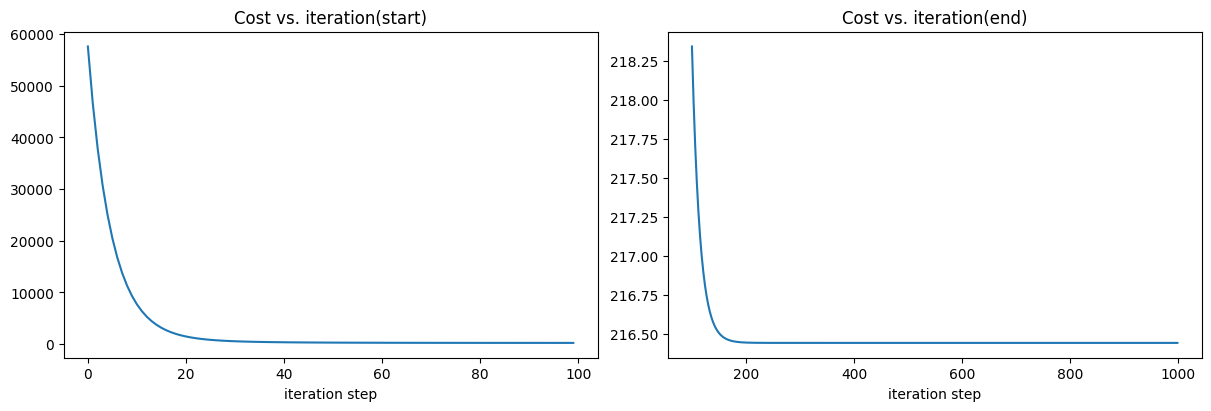

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))

ax1.plot(j_hist[:100])
ax2.plot(100 + np.arange(len(j_hist[100:])), j_hist[100:])

ax1.set_title('Cost vs. iteration(start)')
ax2.set_title('Cost vs. iteration(end)')

ax1.set_xlabel('iteration step')
ax2.set_xlabel(ax1.get_xlabel())

plt.show()

### How do our results compare to `sklearn`?

In [40]:
w, b

(array([110.69, -21.4 , -32.7 , -37.86]), 363.1560606060604)

In [41]:
model = LinearRegression()
model.fit(X_norm, y_train)
model.coef_, model.intercept_

(array([110.69, -21.4 , -32.7 , -37.86]), 363.1560606060606)

### Plot Predictions vs. Target Values

- Note that the predictions are made using normalized features, while the plot is shown using the origianl feature values.

In [42]:
m = X_norm.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_norm[i], w) + b
yp

array([294.07, 486.87, 388.27, 492.5 , 419.16, 222.79, 524.52, 268.41,
       684.86, 181.78, 317.91, 480.54, 409.8 , 393.47, 286.53, 323.28,
       405.42, 436.97, 269.63, 500.35, 329.12, 389.02, 551.33, 241.57,
       296.05, 281.41, 216.88, 490.04, 228.28, 341.34, 290.17, 491.52,
       239.58, 598.11, 383.69, 452.87, 401.22, 405.91, 173.52, 424.98,
       434.45, 276.13, 228.28, 447.96, 488.34, 330.64, 466.8 , 221.63,
       386.81, 456.28, 371.61, 470.03, 310.74, 425.47, 392.25, 347.45,
       340.04, 470.46, 243.44, 297.86, 272.79, 249.53, 297.53, 334.42,
       375.08, 290.15, 228.28, 621.58, 352.53, 511.32, 364.  , 361.89,
       297.53, 406.87, 288.7 , 386.6 , 487.6 , 261.79, 259.35, 428.2 ,
       237.83, 356.51, 340.6 , 390.78, 380.72, 219.78, 434.45, 243.19,
       466.8 , 185.82, 341.09, 411.47, 445.27, 231.66, 330.64, 408.85,
       405.91, 350.61, 274.3 ])

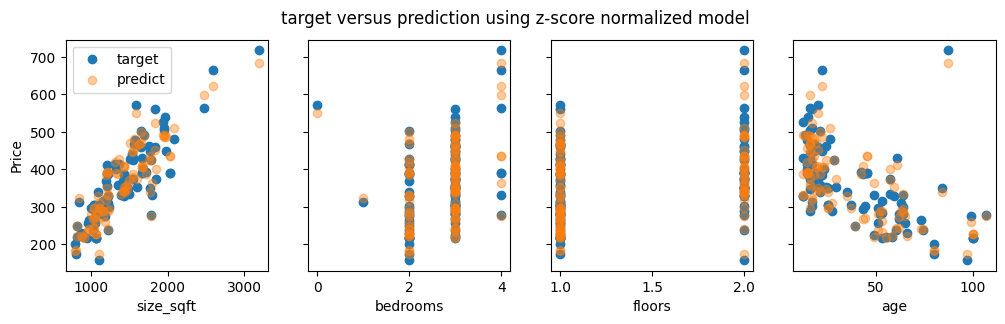

In [43]:
# predictions
y_pred = f_wb(X_norm, w, b)

fig, ax = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:, i], y_train, label='target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(X_train[:, i], y_pred, label='predict', alpha=0.4)
ax[0].set_ylabel('Price')
ax[0].legend()
fig.suptitle("target versus prediction using z-score normalized model")
plt.show()

### Prediction

The point of generating our model is to use it to predict housing prices that are not in the data set. Let's predict the price of a house with 1200 sqft, 3 bedrooms, 1 floor, 40 years old. Recall, that you must normalize the data with the mean and standard deviation derived when the training data was normalized.

In [44]:
x_house = np.array([1200, 3, 1, 40])
x_house_norm = (x_house - X_mu) / X_sigma
x_house_norm

array([-0.53,  0.43, -0.79,  0.06])

In [45]:
f_wb(x_house_norm, w, b)  # in thousands of dollars

318.55129896558714

In [46]:
model.predict(x_house_norm.reshape(1, -1))

array([318.55])